<a href="https://colab.research.google.com/github/mirkhalilrehman/MNIST-GANS/blob/main/mnsit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [13]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert PIL to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    transforms.RandomRotation(10),         # Random rotation within ±10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
])

In [6]:
train_dataset=datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_dataset=datasets.MNIST(root='data',train=False,download=True,transform=transform)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 350kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.57MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [21]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [7]:
def gen_block(inp,out,kernel,stride):
  return nn.Sequential(
      nn.ConvTranspose2d(inp,out,kernel_size=kernel,stride=stride),
      nn.BatchNorm2d(out),
      nn.ReLU()
  )


In [18]:
class Generator(nn.Module):
  def __init__(self,inp,kernel_size=4,stride=2):
    super(Generator, self).__init__()
    self.inp=inp
    self.gen=nn.Sequential(
        gen_block(inp,1024,kernel_size,stride),
        gen_block(1024,512,kernel_size,stride),
        gen_block(512,256,kernel_size,stride),
        nn.ConvTranspose2d(256,1,kernel_size=kernel_size,stride=stride),
        nn.Tanh()
    )

  def forward(self,x):
    x=x.view(len(x),self.inp,1,1)
    return(self.gen(x))


In [10]:
def disc_block(inp, out, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(inp, out, kernel_size, stride=stride),
        nn.BatchNorm2d(out),
        nn.LeakyReLU(0.2))

In [20]:
class Discriminator(nn.Module):
    def __init__(self, kernel_size=4, stride=2):
      super(Discriminator, self).__init__()
      self.disc = nn.Sequential(
          	# Add first discriminator block
            disc_block(1, 512, kernel_size, stride),
            disc_block(512, 1024, kernel_size, stride),
          	# Add a convolution
            nn.Conv2d(1024, 1, kernel_size, stride=stride),
        )


    def forward(self, x):
        # Pass input through sequential block
        x = self.disc(x)
        return x.view(len(x), -1)

In [14]:

def gen_loss(gen, disc, num_images, z_dim):
    # Define random noise
    noise = torch.rand(num_images, z_dim).to(device)

    # Generate fake image
    fake = gen(noise)
    # Get discriminator's prediction on the fake image
    disc_pred =disc(fake)
    # Compute generator loss
    criterion = nn.BCEWithLogitsLoss()
    gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return gen_loss

def disc_loss(gen, disc, real, num_images, z_dim):
    criterion = nn.BCEWithLogitsLoss()
    noise = torch.randn(num_images, z_dim).to(device)
    fake = gen(noise)
    # Get discriminator's predictions for fake images
    disc_pred_fake = disc(fake)
    # Calculate the fake loss component
    fake_loss = criterion(disc_pred_fake,torch.zeros_like(disc_pred_fake))
    # Get discriminator's predictions for real images
    disc_pred_real = disc(real)
    # Calculate the real loss component
    real_loss = criterion(disc_pred_real,torch.ones_like(disc_pred_real))
    disc_loss = (real_loss + fake_loss) / 2
    return disc_loss

In [22]:
gen=Generator(inp=16).to(device)
disc=Discriminator().to(device)

In [23]:
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

Epoch 1/10


100%|██████████| 469/469 [07:38<00:00,  1.02it/s]


Epoch 1: Generator Loss: 0.7359, Discriminator Loss: 0.0019
Epoch 2/10


100%|██████████| 469/469 [07:37<00:00,  1.03it/s]

Epoch 2: Generator Loss: 0.4814, Discriminator Loss: 0.0372


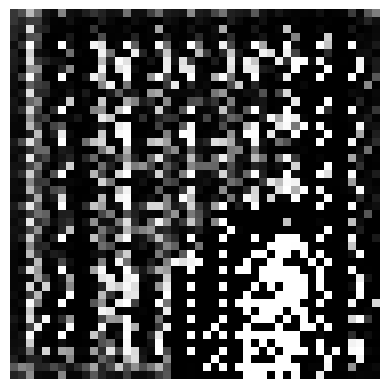

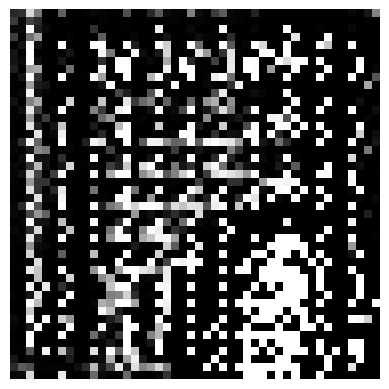

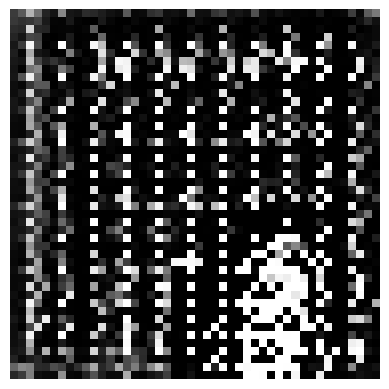

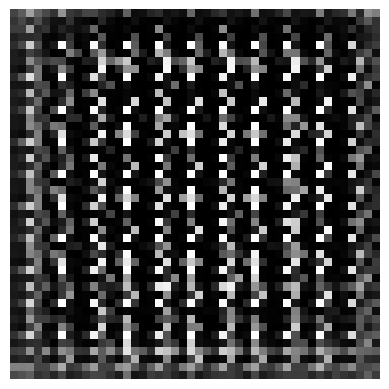

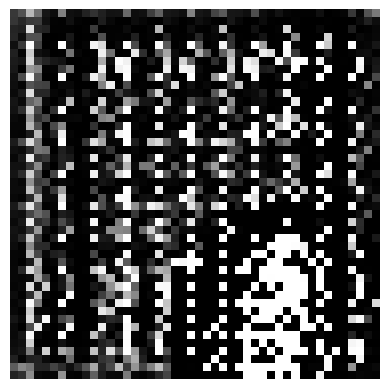

Epoch 3/10


100%|██████████| 469/469 [07:38<00:00,  1.02it/s]


Epoch 3: Generator Loss: 0.0244, Discriminator Loss: 0.0005
Epoch 4/10


100%|██████████| 469/469 [07:37<00:00,  1.03it/s]

Epoch 4: Generator Loss: 0.0204, Discriminator Loss: 0.0003


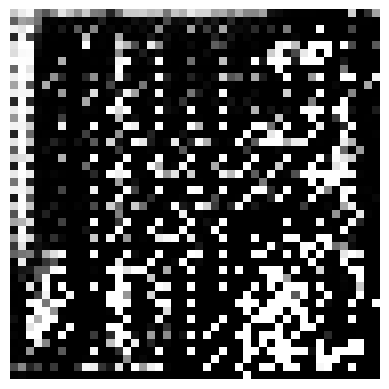

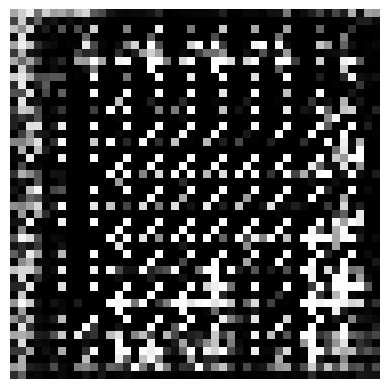

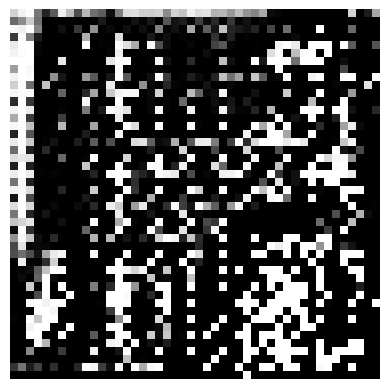

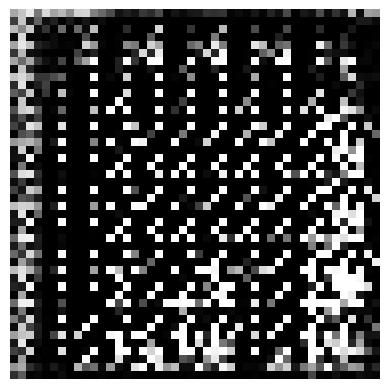

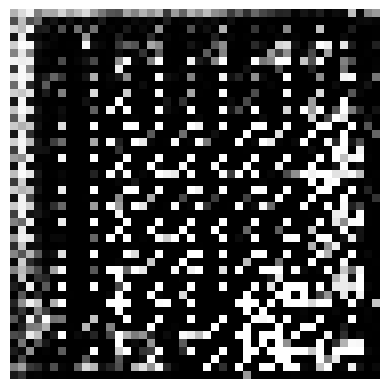

Epoch 5/10


 94%|█████████▍| 443/469 [07:13<00:25,  1.02it/s]

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Denormalization function
def denormalize(tensor, mean=(0.5,), std=(0.5,)):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Scale by std and add mean
    return tensor

# Training Loop
EPOCHS = 10
z_dim = 16

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0

    for real in tqdm(train_loader):  # Use train_loader from the previous code
        real_images = real[0].to(device)
        cur_batch_size = len(real_images)

        # Train Discriminator
        disc_opt.zero_grad()
        disc_loss_val = disc_loss(gen, disc, real_images, cur_batch_size, z_dim=z_dim)
        disc_loss_val.backward()
        disc_opt.step()

        # Train Generator
        gen_opt.zero_grad()
        gen_loss_val = gen_loss(gen, disc, cur_batch_size, z_dim=z_dim)
        gen_loss_val.backward()
        gen_opt.step()

        # Accumulate losses
        epoch_gen_loss += gen_loss_val.item()
        epoch_disc_loss += disc_loss_val.item()

    # Average losses
    avg_gen_loss = epoch_gen_loss / len(train_loader)
    avg_disc_loss = epoch_disc_loss / len(train_loader)

    print(f"Epoch {epoch + 1}: Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

    # Generate and visualize images every few epochs
    if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
        num_images_to_generate = 5
        noise = torch.randn(num_images_to_generate, z_dim).to(device)
        with torch.no_grad():
            fake_images = gen(noise)

        # Visualize generated images
        for i in range(num_images_to_generate):
            image_tensor = fake_images[i].detach().cpu()
            image_tensor = denormalize(image_tensor, mean=(0.5,), std=(0.5,))
            image_tensor = image_tensor.clamp(0, 1)
            image_numpy = image_tensor.squeeze().numpy()  # Remove channel dim for grayscale
            plt.imshow(image_numpy, cmap="gray")
            plt.axis("off")
            plt.show()
